In [30]:
!pip -q install --upgrade pip
!pip -q install "hmmlearn>=0.3.2"


In [31]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Tuple
from hmmlearn.hmm import GaussianHMM
import matplotlib.pyplot as plt

In [32]:
#load weather data for SPI

weekly_SPI = pd.read_csv("weekly_spi6_weibull_only.csv", parse_dates=["date"]) #important columns: date & SPI_6
weekly_SPI.head()

,date,weekly_precip,precip_6mo,SPI_6
0,1970-07-05,29.633333,554.183333,NaN
1,1970-07-12,2.766667,555.350000,NaN
2,1970-07-19,23.783333,572.083333,NaN
3,1970-07-26,7.066667,576.266667,NaN
4,1970-08-02,27.283333,596.383333,NaN


In [33]:
weekly_SPI = weekly_SPI[weekly_SPI['SPI_6'].notna().cummax()]
weekly_SPI.head()
weekly_SPI["SPI_6_raw"] = weekly_SPI["SPI_6"]
if "date" in weekly_SPI.columns:
    weekly_SPI = weekly_SPI.sort_values("date")
else:
    weekly_SPI = weekly_SPI.sort_index()

weekly_SPI["SPI_6"] = weekly_SPI["SPI_6"].ffill()

In [34]:
nan_per_col = weekly_SPI.isna().sum().sort_values(ascending=False)
print(nan_per_col)

SPI_6_raw        8
date             0
weekly_precip    0
precip_6mo       0
SPI_6            0
dtype: int64


In [35]:
#parse dates - to convert date column into pandas date.time and not leave as text
cutoff = pd.Timestamp('2025-07-31')
weekly_SPI = weekly_SPI[weekly_SPI['date'] < cutoff].reset_index(drop=True)

In [36]:
#creating df with columns date and spi_6 for certain functions
ws = weekly_SPI
if 'date' not in ws.columns:
    ws = ws.reset_index().rename(columns={'index': 'date'})

# keep only date + SPI_6, rename to spi_6, normalize date, sort, reindex
weekly_spi = (
    ws.loc[:, ['date', 'SPI_6']]
      .rename(columns={'SPI_6': 'spi_6'})
      .assign(date=lambda d: pd.to_datetime(d['date']))
      .sort_values('date')
      .reset_index(drop=True)
)

# quick check
print(weekly_spi.head())

        date     spi_6
0 1977-07-10 -0.730887
1 1977-07-17 -0.613230
2 1977-07-24 -0.664102
3 1977-07-31 -0.573376
4 1977-08-07 -0.159588


In [37]:
def array(df,date_col, spi_col):
    df = df[[date_col, spi_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    dates = df[date_col]
    X_all = df[spi_col].astype(float).values.reshape(-1,1)
    return X_all

In [38]:
array(weekly_spi,date_col="date", spi_col="spi_6")

array([[-0.73088734],
       [-0.61322969],
       [-0.66410203],
       ...,
       [-0.32556127],
       [-0.12107229],
       [-0.07113322]])

In [39]:
# =========================
# Configuration of model parameters
# =========================
@dataclass
class HMMCfg:
    K_grid: Tuple[int, ...] = ( 3) # set to (2,3,4) when model runs porperly
    covariance_type: str = "diag"   # shared variance (good when data are limited)
    n_init: int = 5 #can increase but model will be slower
    max_iter: int = 300 #The Expectation–Maximization algorithm runs iteratively until convergence (change in log-likelihood < tolerance) - usually before 300 but just to be safe
    random_state: int = 0

@dataclass
class RunCfg:
    first_block_start: str = "1992-01-05"  # train on dates < this; forecast from this date
    block_years: int = 5                   # retrain cadence
    horizons: Tuple[int, ...] = (1,4)      # forecast horizons in weeks


In [40]:
# =========================
# Helper functions
# =========================
def _bic(ll, n_params, n_obs): # hmmlearn doesnt have an inherent bic score function so we set it up here
    return -2*ll + n_params*np.log(max(n_obs,1))

def _param_count_1d(K:int, cov_type:str)->int: #I need to know how many free parameters your HMM has in order to compute the BIC
    # start (K-1) + trans K*(K-1) + means K + variance params
    base = (K-1) + K*(K-1) + K
    return base + (1 if cov_type == "tied" else K) #because var is fixed in tied but not in diag or full

from hmmlearn.hmm import GaussianHMM
import numpy as np

def reorder_states_by_mean(model: GaussianHMM) -> GaussianHMM:
    """
    Reorder states by ascending mean IN-PLACE, safely for all covariance types.
    - Never write to `covars_` for 'tied' (shape is (n_dim, n_dim)).
    - For 'diag' use (K, n_dim) indexing.
    - For 'full' use (K, n_dim, n_dim) indexing.
    - For 'spherical' use (K,) indexing.
    """
    order = np.argsort(model.means_.ravel())
    model.startprob_ = model.startprob_[order]
    model.transmat_  = model.transmat_[order][:, order]
    model.means_     = model.means_[order]

    ct = getattr(model, "covariance_type", None)
    if ct == "diag":
        model.covars_ = model.covars_[order, :]        # (K, n_dim)
    elif ct == "full":
        model.covars_ = model.covars_[order, :, :]     # (K, n_dim, n_dim)
    elif ct == "spherical":
        model.covars_ = model.covars_[order]           # (K,)
    elif ct == "tied":
        pass  # leave as-is
    return model






In [57]:
# =========================
# Helper functions pt2
# =========================

def fit_best_hmm_1d(X: np.ndarray, cfg: HMMCfg) -> GaussianHMM:
    """Fit over K_grid, pick best by BIC, reorder states by mean (dry->wet)."""
    X = np.asarray(X).reshape(-1, 1)
    if not np.isfinite(X).all():
        raise ValueError("X contains NaN/Inf")

    best_bic, best_model = np.inf, None
    for K in cfg.K_grid:
        best_ll, best_k = -np.inf, None
        for seed in range(cfg.n_init):
            m = GaussianHMM(
                n_components=K,
                covariance_type=cfg.covariance_type,
                n_iter=cfg.max_iter,
                random_state=cfg.random_state + seed
            )
            m.fit(X)
            ll = m.score(X)
            if ll > best_ll:
                best_ll, best_k = ll, m

        bic = _bic(best_ll, _param_count_1d(K, cfg.covariance_type), len(X))
        if bic < best_bic:
            best_bic, best_model = bic, best_k

    if best_model is None:
        raise RuntimeError("No successful fits.")

    # ✅ Use the new, in-place reordering (NO underscore)
    return reorder_states_by_mean(best_model)

# in order to get 4 weeks ahead transition prob we need to get a function that calc the trans prob matrix for four weeks in advance
def T_power(T: np.ndarray, h: int) -> np.ndarray:
    return np.linalg.matrix_power(T, h)

def causal_state_probs_at_t(model: GaussianHMM, X_all: np.ndarray, t: int) -> np.ndarray:
    """
    Causal state probabilities at time t using hmmlearn only:
    run predict_proba on the PREFIX X[:t+1] and take the last row.
    (No future observations beyond t are used.)
    """
    post = model.predict_proba(X_all[:t+1])   # (t+1, K)
    return post[-1]                            # (K,)


In [58]:
from hmmlearn.hmm import GaussianHMM
import numpy as np

def fit_best_hmm_1d(X, cfg):
    assert X.ndim == 2 and X.shape[1] == 1, "X must be (n_samples, 1)"
    n = len(X)
    best, best_bic = None, np.inf

    for K in cfg.K_grid:
        for seed in range(cfg.n_init):
            m = GaussianHMM(
                n_components=K,
                covariance_type=cfg.covariance_type,  # 'diag'
                n_iter=cfg.max_iter,
                random_state=cfg.random_state + seed,
                verbose=cfg.verbose,
            ).fit(X)

            logL = m.score(X)
            # 1D, diag: startprob(K-1) + trans(K*(K-1)) + means(K) + covars(K)
            p = (m.n_components - 1) + m.n_components*(m.n_components - 1) + m.n_components + m.n_components
            bic = -2*logL + p*np.log(n)
            if bic < best_bic:
                best_bic, best = bic, m

    if best is None:
        raise RuntimeError("No HMM fit succeeded.")
    return best

def state_order_by_mean(model):
    """Return permutation that sorts states by ascending mean (no mutation)."""
    return np.argsort(model.means_.ravel())

def permute_T(T, order):
    """Apply a state permutation to a transition matrix (no mutation)."""
    return T[order][:, order]


In [51]:
from hmmlearn.hmm import GaussianHMM
import numpy as np
from dataclasses import dataclass

# ---------------------------
# 1) Safe reorder + shape guard
# ---------------------------
def _ensure_diag_shape(model: GaussianHMM, n_dim: int = 1):
    """Ensure diag covars have shape (K, n_dim) and are positive."""
    if model.covariance_type != "diag":
        return
    cov = model.covars_
    # unsqueeze if someone squeezed it
    if cov.ndim == 1:
        cov = cov[:, None]                 # (K,) -> (K,1)
    elif cov.ndim == 0:
        cov = np.array([[float(cov)]])     # scalar -> (1,1)
    # if n_dim got lost, force to (K, n_dim)
    if cov.shape[1] != n_dim:
        cov = cov.reshape(cov.shape[0], 1) # for 1D use-case
    # guard positivity (hmmlearn requires > 0)
    cov = np.maximum(cov, 1e-12)
    model.covars_ = cov

def reorder_states_by_mean(model: GaussianHMM) -> GaussianHMM:
    """Reorder states by ascending mean IN-PLACE, handling all covariance types safely."""
    order = np.argsort(model.means_.ravel())
    model.startprob_ = model.startprob_[order]
    model.transmat_  = model.transmat_[order][:, order]
    model.means_     = model.means_[order]

    ct = getattr(model, "covariance_type", None)
    if ct == "diag":
        model.covars_ = model.covars_[order, :]         # (K, n_dim)
    elif ct == "full":
        model.covars_ = model.covars_[order, :, :]      # (K, n_dim, n_dim)
    elif ct == "spherical":
        model.covars_ = model.covars_[order]            # (K,)
    elif ct == "tied":
        pass                                            # (n_dim, n_dim) -> leave as is
    return model

# ---------------------------
# 2) Fit best HMM (never construct covars_ yourself)
# ---------------------------
@dataclass
class HMMCfg:
    K_grid: tuple = (2, 3, 4)
    covariance_type: str = "diag"
    n_init: int = 5
    max_iter: int = 300
    random_state: int = 42
    verbose: bool = False

def fit_best_hmm_1d(X, cfg: HMMCfg) -> GaussianHMM:
    assert X.ndim == 2 and X.shape[1] == 1, "X must be (n_samples, 1)"
    n = len(X)
    best, best_bic = None, np.inf

    for K in cfg.K_grid:
        for seed in range(cfg.n_init):
            m = GaussianHMM(
                n_components=K,
                covariance_type=cfg.covariance_type,  # 'diag'
                n_iter=cfg.max_iter,
                random_state=cfg.random_state + seed,
                verbose=cfg.verbose,
            ).fit(X)

            # SAFE: enforce diag shape, then reorder safely, then enforce again
            _ensure_diag_shape(m, n_dim=1)
            reorder_states_by_mean(m)
            _ensure_diag_shape(m, n_dim=1)

            # BIC = -2 logL + p log n  (1D diag -> p = (K-1) + K*(K-1) + K + K)
            logL = m.score(X)
            p = (K - 1) + K*(K - 1) + K + K
            bic = -2*logL + p*np.log(n)

            if bic < best_bic:
                best_bic, best = bic, m

    if best is None:
        raise RuntimeError("No HMM fit succeeded.")

    # Final paranoia checks
    if best.covariance_type == "diag":
        assert best.covars_.shape == (best.n_components, 1), f"diag covars bad shape: {best.covars_.shape}"
        assert np.all(best.covars_ > 0), "diag covars must be positive"
    return best


In [59]:
# =========================
# Main: train-then-freeze, 5y blocks, per-state probs only
# =========================
def hmm_per_state_blockwise(df: pd.DataFrame,#input df with both date and spi
                            date_col="date", spi_col="spi_6",
                            hmm_cfg=HMMCfg(), run_cfg=RunCfg()):
    """
    - Train on dates < first_block_start.
    - For each 5-year block: refit on dates < block start (expanding window),
      then freeze and forecast each week in the block without using future weeks.
    - Output per-state probabilities at each horizon (no aggregates).
    """
    df = df[[date_col, spi_col]].copy()
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col).reset_index(drop=True)

    dates = df[date_col]
    X_all = df[spi_col].astype(float).values.reshape(-1, 1)

    #It'll train on data < block start and forecast within the block
    first_start = pd.Timestamp(run_cfg.first_block_start)
    last_date   = dates.iloc[-1]
    start_year  = first_start.year
    end_year    = last_date.year
    block_starts = [pd.Timestamp(year=y, month=1, day=1)
                    for y in range(start_year, end_year+1, run_cfg.block_years)]

    #Start the output table (will add columns as we go)
    out = df[[date_col, spi_col]].copy()
    made_cols_for = set()  # remember (K, horizons) we've added columns for

    for b_start in block_starts:
        b_end_excl = pd.Timestamp(year=b_start.year + run_cfg.block_years, month=1, day=1)
        b_end = min(b_end_excl - pd.Timedelta(days=1), last_date) # compute the inclusive end date - 5y minus 1 day

        train_mask = dates < b_start
        if train_mask.sum() < 50:
            print(f"Skip block {b_start.date()}–{b_end.date()} (not enough training data).")
            continue
        # fit the best HMM on the training prefix
        # fit the best HMM on the training prefix
        X_train = X_all[train_mask.values]
        model   = fit_best_hmm_1d(X_train, hmm_cfg)
        T_raw   = model.transmat_
        K       = model.n_components

        # --- NEW: compute order by mean, but DO NOT mutate the model
        order   = state_order_by_mean(model)
        T       = permute_T(T_raw, order)            # ordered transition matrix

        # prepare output columns (unchanged)
        key = (K, tuple(sorted(run_cfg.horizons)))
        if key not in made_cols_for:
            for h in run_cfg.horizons:
                for s in range(K):
                    col = f"p_state{s}_h{h}"
                    if col not in out.columns:
                        out[col] = np.nan
            made_cols_for.add(key)

        # matrix powers in the ordered state space
        Tpow = {h: T_power(T, h) for h in run_cfg.horizons}

        # indices inside this block (unchanged)
        block_mask = (dates >= b_start) & (dates <= b_end)
        idxs = np.where(block_mask)[0]

        for t in idxs:
            # posterior at time t in the **original** state order
            g_t_raw = causal_state_probs_at_t(model, X_all, t)      # shape (K,)

            # --- NEW: reorder the posterior by mean **without** touching the model
            g_t_ord = g_t_raw[order]                                # shape (K,)

            for h in run_cfg.horizons:
                g_th = g_t_ord @ Tpow[h]                            # (K,)
                for s in range(K):
                    out.at[t, f"p_state{s}_h{h}"] = float(g_th[s])


        #block summary in the notebook output
        print(f"Block {b_start.date()}–{b_end.date()}: "
              f"train_weeks={train_mask.sum()}, block_weeks={block_mask.sum()}, K={K}")

    return out


In [60]:
# ===========
# Computing the model - execution
# ===========

results = hmm_per_state_blockwise(
    df = weekly_spi, date_col="date", spi_col="spi_6",
    hmm_cfg=HMMCfg(covariance_type="diag", K_grid=(2,3), n_init=5, max_iter=300),
    run_cfg=RunCfg(first_block_start="1992-01-05", block_years=5, horizons=(1,4))
)


Block 1992-01-01–1996-12-31: train_weeks=756, block_weeks=261, K=3
Block 1997-01-01–2001-12-31: train_weeks=1017, block_weeks=261, K=3
Block 2002-01-01–2006-12-31: train_weeks=1278, block_weeks=261, K=3
Block 2007-01-01–2011-12-31: train_weeks=1539, block_weeks=260, K=3
Block 2012-01-01–2016-12-31: train_weeks=1799, block_weeks=261, K=3
Block 2017-01-01–2021-12-31: train_weeks=2060, block_weeks=261, K=3
Block 2022-01-01–2025-07-27: train_weeks=2321, block_weeks=187, K=3


In [61]:
def save_h1_probs_csv(
    results: pd.DataFrame,
    out_path: str = "state_probs_h1.csv",
    date_col: str = "date",
    start_date: str | None = "1992-01-01",
):
    df = results.copy()

    # Ensure datetime index for filtering/sorting
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).set_index(date_col)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Provide a datetime 'date' column or use a DatetimeIndex.")

    # Grab all h=1 state probability columns
    prob_cols = [c for c in df.columns if c.startswith("p_state") and c.endswith("_h1")]
    if not prob_cols:
        raise KeyError("No state probability columns for h=1 found (e.g., 'p_state0_h1').")

    # Optional start-date filter
    if start_date is not None:
        df = df.loc[df.index >= pd.to_datetime(start_date)]

    # Build output with date as a column
    out = df[prob_cols].copy()
    out.insert(0, "date", out.index)  # move datetime index to a column

    # Save
    out.to_csv(out_path, index=False)
    return out_path

# --- usage ---
path = save_h1_probs_csv(results, out_path="h1_probs.csv")



In [62]:
#plotting dry period probs

def plot_state0_probs(results: pd.DataFrame, horizons=(1, 4), title="State 0 (driest) probabilities over time"):
    """
    Plots p_state0_h{h} over time for the given horizons.
    Expects columns: 'date', and for each h in horizons, 'p_state0_h{h}'.
    """
    # Ensure datetime & sort
    df = results.copy()
    if 'date' not in df.columns:
        raise ValueError("Expected a 'date' column in results.")
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values('date').reset_index(drop=True)

    # Prepare figure
    plt.figure(figsize=(12, 4))

    # Plot each horizon if present
    plotted_any = False
    for h in horizons:
        col = f"p_state0_h{h}"
        if col in df.columns:
            plt.plot(df['date'], df[col], label=f"h={h}")
            plotted_any = True
        else:
            print(f"[warn] Column '{col}' not found; skipping.")

    if not plotted_any:
        raise ValueError(f"None of the requested horizons found: {horizons}. "
                         f"Available columns: {[c for c in results.columns if c.startswith('p_state0_h')]}")

    plt.ylabel("Probability")
    plt.xlabel("Date")
    plt.title(title)
    plt.ylim(0.0, 1.0)
    plt.grid(True, linewidth=0.5, alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

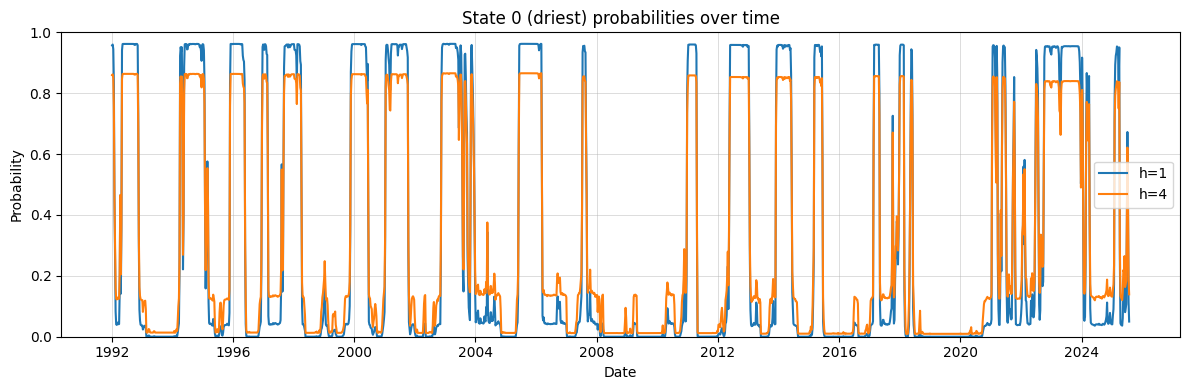

In [63]:
plot_state0_probs(results, horizons=(1, 4))

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_spi_with_bands(
    df: pd.DataFrame,
    date_col: str = "date",
    spi_col: str = "SPI_6",
    title: str = "Standardized Precipitation Index (SPI)",
    start_date: str = "1992-01-01",   # 👈 NEW: filter lower bound
    bands=None,
    show_legend: bool = True,
    annotate_right: bool = True,
    figsize=(12, 5),
    savepath: str | None = None,
):
    """
    Plot SPI over time with horizontal classification bands,
    starting from start_date.
    """

    # --- Prep data
    df = df.copy()
    if not np.issubdtype(df[date_col].dtype, np.datetime64):
        df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(date_col)

    # Filter from start_date
    if start_date is not None:
        start_date = pd.to_datetime(start_date)
        df = df[df[date_col] >= start_date]

    x = df[date_col].to_numpy()
    y = df[spi_col].to_numpy()

    if len(df) == 0:
        raise ValueError(f"No data on or after {start_date}.")

    # Default SPI bands (low, high, label, color)
    if bands is None:
        bands = [
            (-np.inf, -2.0, "Extreme drought (≤ -2.0)",     "#7f0000"),
            (-2.0,    -1.5, "Severe drought [-2.0,-1.5)",   "#b30000"),
            (-1.5,    -1.0, "Moderate drought [-1.5,-1.0)", "#e34a33"),
            (-1.0,     1.0, "Near normal (-1.0,1.0)",       "#f7f7f7"),
            ( 1.0,     1.5, "Moderately wet [1.0,1.5)",     "#a1d99b"),
            ( 1.5,     2.0, "Very wet [1.5,2.0)",           "#31a354"),
            ( 2.0,    np.inf,"Extremely wet (≥ 2.0)",       "#006d2c"),
        ]

    # --- Plot
    fig, ax = plt.subplots(figsize=figsize)

    # Shade bands
    ymin = np.nanmin(y)
    ymax = np.nanmax(y)
    pad = 0.2 * (ymax - ymin if ymax != ymin else 2.0)
    ylo = ymin - pad
    yhi = ymax + pad

    legend_patches = []
    for low, high, label, color in bands:
        lo = low if np.isfinite(low) else ylo
        hi = high if np.isfinite(high) else yhi
        ax.axhspan(lo, hi, facecolor=color, alpha=0.18, edgecolor="none")
        legend_patches.append(Patch(facecolor=color, alpha=0.5, label=label))

        if annotate_right:
            y_mid = ( (lo if np.isfinite(low) else -1) + (hi if np.isfinite(high) else 1) ) / 2.0
            ax.text(
                x.max(), y_mid, label.split(" (")[0],
                va="center", ha="right", fontsize=9, alpha=0.8,
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.6, pad=1.5)
            )

    # SPI line
    ax.plot(x, y, lw=1.6, color="steelblue")

    # Zero line
    ax.axhline(0.0, color="k", lw=1.0, alpha=0.7)

    # Style
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel(spi_col)
    ax.set_ylim(ylo, yhi)
    ax.grid(alpha=0.3)

    if show_legend:
        ax.legend(handles=legend_patches, loc="upper left", frameon=True, fontsize=8)

    plt.tight_layout()
    if savepath is not None:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()


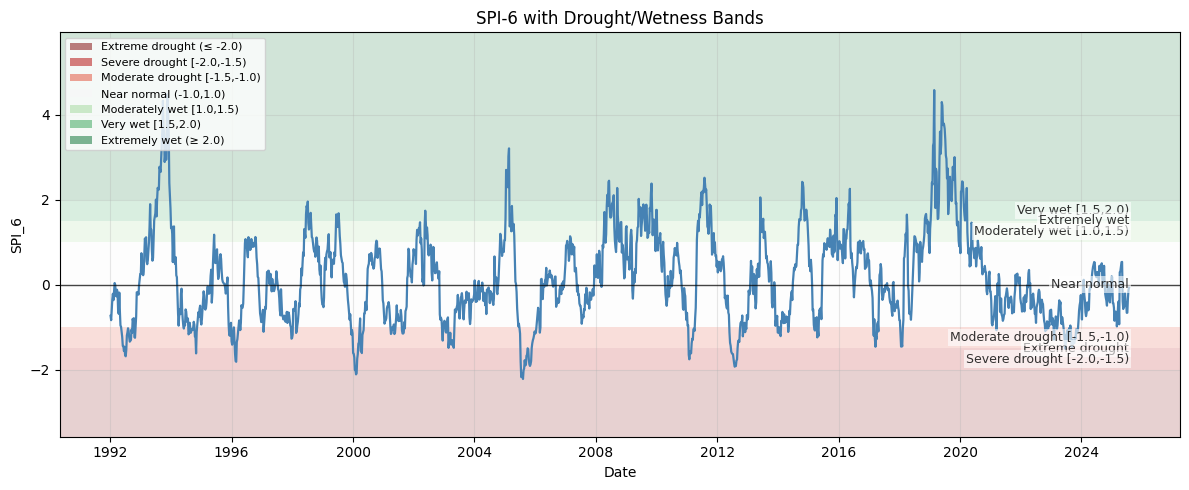

In [65]:
# weekly_SPI: columns ["date", "SPI_6"]
plot_spi_with_bands(weekly_SPI, date_col="date", spi_col="SPI_6",
                    title="SPI-6 with Drought/Wetness Bands")


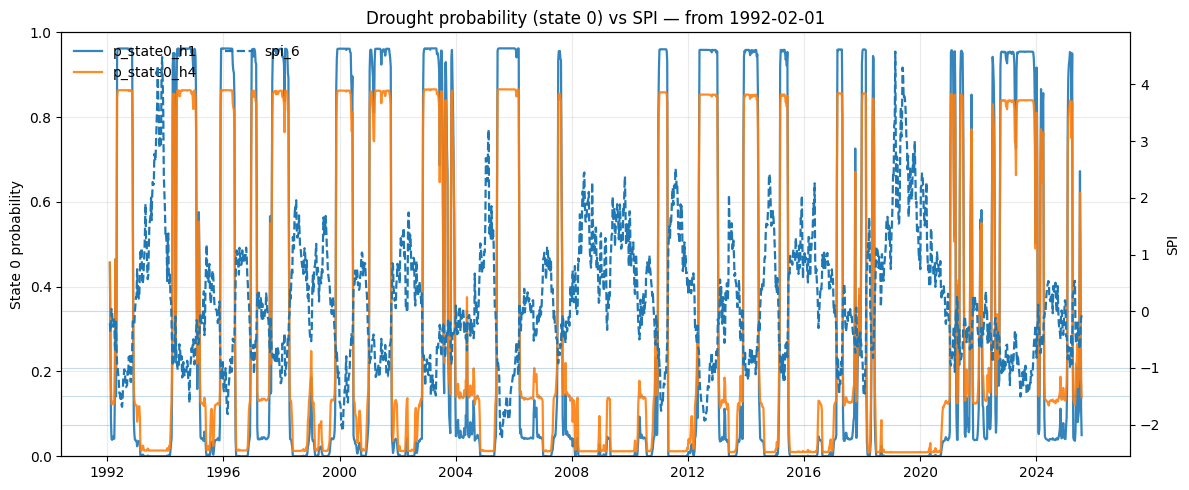

In [66]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_drought_prob_and_spi(
    results: pd.DataFrame,
    date_col: str = "date",
    spi_col: str = "spi_6",
    prob_cols: tuple[str, ...] = ("p_state0_h1", "p_state0_h4"),
    start_date: str = "1992-02-01",
    figsize=(12, 5)
):
    """
    Line chart of state-0 probabilities and SPI on the same figure.
    - Left y-axis: probabilities (0..1)
    - Right y-axis: SPI values
    - Filters data to dates >= start_date
    """
    df = results.copy()

    # Ensure datetime index for filtering/plotting
    if date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).set_index(date_col)
    elif not isinstance(df.index, pd.DatetimeIndex):
        raise ValueError("Provide a datetime 'date' column or index must be a DatetimeIndex.")

    # Keep only needed cols that exist
    avail_probs = [c for c in prob_cols if c in df.columns]
    needed = [spi_col] + avail_probs
    missing = [c for c in [spi_col] + list(prob_cols) if c not in df.columns]
    if spi_col not in df.columns:
        raise KeyError(f"Missing SPI column: {spi_col}")
    if not avail_probs:
        raise KeyError(f"None of the probability columns found: {prob_cols}")
    if missing:
        print(f"Note: missing columns not plotted: {missing}")

    plot_df = df.loc[df.index >= pd.to_datetime(start_date), needed].copy()

    fig, ax_prob = plt.subplots(figsize=figsize)

    # Plot probabilities (left axis)
    handles = []
    labels = []
    for i, c in enumerate(avail_probs):
        (ln,) = ax_prob.plot(plot_df.index, plot_df[c], lw=1.6, alpha=0.9, label=c)
        handles.append(ln); labels.append(c)

    ax_prob.set_ylabel("State 0 probability")
    ax_prob.set_ylim(0, 1)
    ax_prob.grid(True, which="major", axis="both", alpha=0.25)

    # SPI on right axis
    ax_spi = ax_prob.twinx()
    (ln_spi,) = ax_spi.plot(plot_df.index, plot_df[spi_col], lw=1.6, linestyle="--", label=spi_col)
    ax_spi.set_ylabel("SPI")
    # Light guides for common SPI categories
    for y in [0.0, -1.0, -1.5, -2.0]:
        ax_spi.axhline(y=y, lw=0.8, alpha=0.25)

    # Legend (combine both axes)
    handles2, labels2 = ax_spi.get_legend_handles_labels()
    handles_all = handles + handles2
    labels_all  = labels + labels2
    ax_prob.legend(handles_all, labels_all, loc="upper left", frameon=False, ncol=2)

    title_probs = ", ".join(avail_probs)
    ax_prob.set_title(f"Drought probability (state 0) vs SPI — from {pd.to_datetime(start_date).date()}")

    fig.tight_layout()
    plt.show()

# ---- usage ----
plot_drought_prob_and_spi(results)


In [67]:

def spi_prob_lagged_corr(
    results: pd.DataFrame,
    spi_col: str = "spi_6",
    prob_cols: tuple[str, str] = ("p_state0_h1", "p_state0_h4"),
    date_col: str | None = "date",
    start_date: str = "1992-02-01",
    max_lag_weeks: int = 52,
) -> pd.DataFrame:
    """
    Correlate today's SPI with state-0 probabilities from the same day (lag=0)
    and from 1..max_lag_weeks weeks ago.

    Returns a DataFrame with columns:
      lag_weeks, corr_h1, n_h1, corr_h4, n_h4
    """
    df = results.copy()

    # Ensure we have a datetime index/column for filtering and sort by date
    if date_col and date_col in df.columns:
        df[date_col] = pd.to_datetime(df[date_col])
        df = df.sort_values(date_col).set_index(date_col)
    else:
        # assume index is already datetime-like
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError("Provide a datetime 'date' column or use a DatetimeIndex.")
        df = df.sort_index()

    # Keep only the needed columns & from start_date
    needed = [spi_col, *prob_cols]
    missing = [c for c in needed if c not in df.columns]
    if missing:
        raise KeyError(f"Missing required column(s): {missing}")

    df = df.loc[df.index >= pd.to_datetime(start_date), needed].copy()

    # Prepare output container
    out_rows = []
    h1, h4 = prob_cols

    # Compute correlations for lags 0..max_lag_weeks
    for lag in range(0, max_lag_weeks + 1):
        # Align: correlate SPI_t with prob_{t - lag}
        prob_h1_lag = df[h1].shift(lag)
        prob_h4_lag = df[h4].shift(lag)

        # Pairwise-drop NaNs per pair
        s_spi = df[spi_col]

        # h1
        mask_h1 = s_spi.notna() & prob_h1_lag.notna()
        corr_h1 = np.nan
        n_h1 = int(mask_h1.sum())
        if n_h1 >= 2:
            corr_h1 = float(s_spi[mask_h1].corr(prob_h1_lag[mask_h1]))

        # h4
        mask_h4 = s_spi.notna() & prob_h4_lag.notna()
        corr_h4 = np.nan
        n_h4 = int(mask_h4.sum())
        if n_h4 >= 2:
            corr_h4 = float(s_spi[mask_h4].corr(prob_h4_lag[mask_h4]))

        out_rows.append({
            "lag_weeks": lag,
            "corr_h1": corr_h1,
            "n_h1": n_h1,
            "corr_h4": corr_h4,
            "n_h4": n_h4,
        })

    out = pd.DataFrame(out_rows).set_index("lag_weeks")
    return out

# ---- usage ----


In [68]:
 corr_table = spi_prob_lagged_corr(results)
 corr_table.head(), corr_table.loc[[0,1,4,12,26,52]]
# If you want the best (most negative/positive) lag quickly:
# best_neg_h1 = corr_table['corr_h1'].idxmin()
# best_pos_h1 = corr_table['corr_h1'].idxmax()
# best_neg_h4 = corr_table['corr_h4'].idxmin()
# best_pos_h4 = corr_table['corr_h4'].idxmax()




(            corr_h1  n_h1   corr_h4  n_h4
 lag_weeks                                
 0         -0.748143  1748 -0.788781  1748
 1         -0.718206  1747 -0.757876  1747
 2         -0.688192  1746 -0.726708  1746
 3         -0.657575  1745 -0.695200  1745
 4         -0.626289  1744 -0.663208  1744,
             corr_h1  n_h1   corr_h4  n_h4
 lag_weeks                                
 0         -0.748143  1748 -0.788781  1748
 1         -0.718206  1747 -0.757876  1747
 4         -0.626289  1744 -0.663208  1744
 12        -0.398396  1736 -0.425276  1736
 26        -0.003535  1722 -0.014356  1722
 52         0.049319  1696  0.050114  1696)

In [69]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss

def add_spi3class_and_score(
    df: pd.DataFrame,
    *,
    spi_col: str = "spi_6",
    horizon: int = 1,                          # compare probs at t to SPI class at t+h
    prob_col_tpl: str = "p_state{state}_h{h}", # how your columns are named
    dry_thr: float = -0.5,
    wet_thr: float =  0.5,
    train_mask: pd.Series | np.ndarray | None = None,   # boolean mask used to learn mapping
    state_to_class: dict[int, int] | None = None        # optional manual mapping {state: 0/1/2}
):
    """
    Adds 3-class SPI labels and scores HMM classification for a given horizon.

    df must already contain the state-probability columns for the chosen horizon, e.g.:
      p_state0_h1, p_state1_h1, p_state2_h1  (for horizon=1)

    Returns:
      metrics: dict with accuracy, confusion matrix, per-class report, brier-ish score,
               log loss (if all probs > 0), and the inferred state->class mapping.
      df: with new columns:
            - 'spi3' (0=dry,1=neutral,2=wet) at time t
            - 'spi3_tplus{h}' target labels at time t+h
            - 'pred3_{h}' argmax class predicted at time t
            - 'proba3_{h}_dry', 'proba3_{h}_neutral', 'proba3_{h}_wet'
    """
    C = 3
    h = horizon

    # 0) Build SPI -> 3-class labels at t and t+h
    def spi_to_3(spi):
        y = np.full_like(spi, 1, dtype=int)   # neutral
        y[spi <= dry_thr] = 0                 # dry
        y[spi >=  wet_thr] = 2               # wet
        return y

    df = df.copy()
    df["spi3"] = spi_to_3(df[spi_col].to_numpy())
    df[f"spi3_tplus{h}"] = df["spi3"].shift(-h)   # target at t+h

    # 1) Collect the K=3 probability columns for this horizon
    prob_cols = [prob_col_tpl.format(state=s, h=h) for s in range(3)]
    for c in prob_cols:
        if c not in df.columns:
            raise ValueError(f"Missing column: {c}")

    P = df[prob_cols].to_numpy()  # shape (T, 3), rows sum ~1
    T, K = P.shape
    assert K == 3, "This helper assumes K=3 states."

    # 2) Learn or use a mapping: state -> class (0=dry,1=neutral,2=wet)
    #    If not provided, infer on the training slice by ordering states by mean SPI
    #    (lowest mean -> dry, middle -> neutral, highest -> wet).
    if state_to_class is None:
        if train_mask is None:
            # default: use all non-na rows up to where target exists
            train_mask = pd.Series(True, index=df.index)
        else:
            train_mask = pd.Series(train_mask, index=df.index)

        # Use only rows where SPI and probs exist AND target exists (avoid leakage)
        valid_train = train_mask & df[spi_col].notna() & (~df[f"spi3_tplus{h}"].isna())
        if valid_train.sum() < 10:
            # fallback: just order by overall mean if train slice too small
            valid_train = df[spi_col].notna()

        spi_vals = df.loc[valid_train, spi_col].to_numpy()
        P_train  = P[valid_train.to_numpy(), :]

        # weighted mean SPI per state (soft responsibilities)
        state_means = []
        for s in range(3):
            w = P_train[:, s]
            denom = w.sum()
            m = (w @ spi_vals) / denom if denom > 0 else np.inf
            state_means.append(m)

        # map by ascending mean: low -> dry(0), mid -> neutral(1), high -> wet(2)
        order = np.argsort(state_means)  # indices of states from driest to wettest
        inferred_mapping = {int(order[0]): 0, int(order[1]): 1, int(order[2]): 2}
        mapping = inferred_mapping
    else:
        mapping = dict(state_to_class)

    # 3) Aggregate state probabilities into class probabilities at time t
    proba3 = np.zeros((T, C), dtype=float)
    for s, c in mapping.items():
        proba3[:, c] += P[:, s]

    # 4) Hard prediction at time t (argmax over class probs)
    y_pred = proba3.argmax(axis=1)

    # 5) Targets are SPI class at t+h
    y_true = df[f"spi3_tplus{h}"].to_numpy()

    # 6) Keep only rows where target exists
    mask_eval = ~np.isnan(y_true)
    y_true = y_true[mask_eval].astype(int)
    y_pred_eval = y_pred[mask_eval]
    proba3_eval = proba3[mask_eval]

    # 7) Metrics
    acc = accuracy_score(y_true, y_pred_eval)
    cm  = confusion_matrix(y_true, y_pred_eval, labels=[0,1,2])
    report = classification_report(
        y_true, y_pred_eval, labels=[0,1,2],
        target_names=["dry","neutral","wet"], digits=3
    )

    # Brier-like score (mean squared error of the prob vector vs. one-hot)
    one_hot = np.eye(3)[y_true]
    brier = float(np.mean((proba3_eval - one_hot) ** 2))

    # log loss (guard against zeros)
    eps = 1e-12
    proba_safe = np.clip(proba3_eval, eps, 1 - eps)
    ll = log_loss(y_true, proba_safe, labels=[0,1,2])

    # 8) Attach columns
    df[f"proba3_{h}_dry"]     = proba3[:, 0]
    df[f"proba3_{h}_neutral"] = proba3[:, 1]
    df[f"proba3_{h}_wet"]     = proba3[:, 2]
    df[f"pred3_{h}"]          = y_pred

    metrics = {
        "horizon": h,
        "state_to_class": mapping,         # {state: 0/1/2}
        "accuracy": acc,
        "confusion_matrix": cm,
        "classification_report": report,
        "brier_like": brier,
        "log_loss": ll
    }
    return df, metrics


In [70]:
data = results.dropna().copy()
print(data)

           date     spi_6  p_state0_h1  p_state1_h1  p_state2_h1  p_state0_h4  \
756  1992-01-05 -0.732003     0.956901     0.042830     0.000269     0.859530   
757  1992-01-12 -0.834133     0.959909     0.039983     0.000108     0.861944   
758  1992-01-19 -0.591965     0.944743     0.054335     0.000922     0.849776   
759  1992-01-26 -0.342588     0.830881     0.161985     0.007134     0.758414   
760  1992-02-02 -0.213558     0.455904     0.515776     0.028321     0.457470   
...         ...       ...          ...          ...          ...          ...   
2503 2025-06-29 -0.661531     0.348264     0.620328     0.031407     0.370321   
2504 2025-07-06 -0.658827     0.672523     0.312855     0.014622     0.621480   
2505 2025-07-13 -0.325561     0.440296     0.534179     0.025524     0.441718   
2506 2025-07-20 -0.121072     0.113754     0.844097     0.042149     0.188818   
2507 2025-07-27 -0.071133     0.049843     0.904381     0.045776     0.139283   

      p_state1_h4  p_state2

In [71]:
# Example: evaluate 1-week-ahead classification using columns p_state{0,1,2}_h1
df_scored, m1 = add_spi3class_and_score(
    data,
    spi_col="spi_6",
    horizon=1,
    prob_col_tpl="p_state{state}_h1",
    # train_mask = weekly_spi.index < pd.Timestamp("1992-01-05")  # e.g., per-block
)

print(m1["accuracy"])
print(m1["classification_report"])

# grab the count matrix you already computed
cm = np.array(m1["confusion_matrix"], dtype=float)
labels = ["dry", "neutral", "wet"]
# --- Row-normalized (% of true class) ---
row_den = cm.sum(axis=1, keepdims=True)
cm_row_pct = np.divide(cm, row_den, out=np.zeros_like(cm), where=row_den!=0) * 100
row_df = pd.DataFrame(cm_row_pct, index=[f"true_{l}" for l in labels],
                      columns=[f"pred_{l}" for l in labels]).round(1)
print("\nConfusion matrix – % of TRUE class (rows sum to 100):")
print(row_df)
# For 4-week-ahead, just change horizon
#_, m4 = add_spi3class_and_score(weekly_spi, spi_col="spi_6", horizon=4)


0.8206739006282124
              precision    recall  f1-score   support

         dry      0.839     0.844     0.842       539
     neutral      0.749     0.719     0.733       597
         wet      0.869     0.899     0.884       615

    accuracy                          0.821      1751
   macro avg      0.819     0.821     0.820      1751
weighted avg      0.819     0.821     0.820      1751


Confusion matrix – % of TRUE class (rows sum to 100):
              pred_dry  pred_neutral  pred_wet
true_dry          84.4          15.6       0.0
true_neutral      14.2          71.9      13.9
true_wet           0.3           9.8      89.9
